In [2]:
import sys
sys.path.append("..")
sys.path.append("../neurontree/")

import NeuronTree as nt
import pandas as pd

In [2]:


import networkx as nx
import numpy as np


# PLOTTING


# Load file

In [3]:
# TODO change with new loading function
swc = pd.read_csv("../data/EC3-80604.CNG.swc",delim_whitespace=True, comment='#',
                              names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'], index_col=False)

N = nt.NeuronTree(swc)

# Plotting

Each NeuronTree object comes with its own plotting function `draw_2D()`. The parameter `projection` let's you choose which 2D projection to plot.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

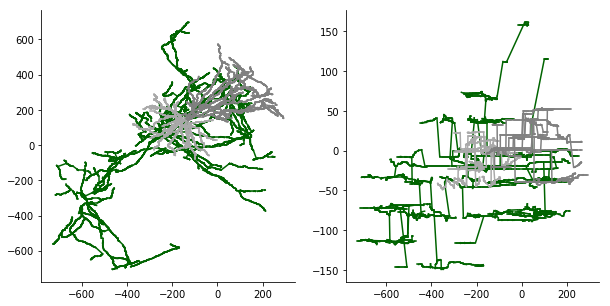

In [7]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
N.draw_2D(fig, ax=ax1, projection='xy')

ax2= plt.subplot(122)
N.draw_2D(fig, ax=ax2, projection='xz')

sns.despine()

In case you want to check out all of the three possible 2D projections at once you can also use the provided `show_threeview()`

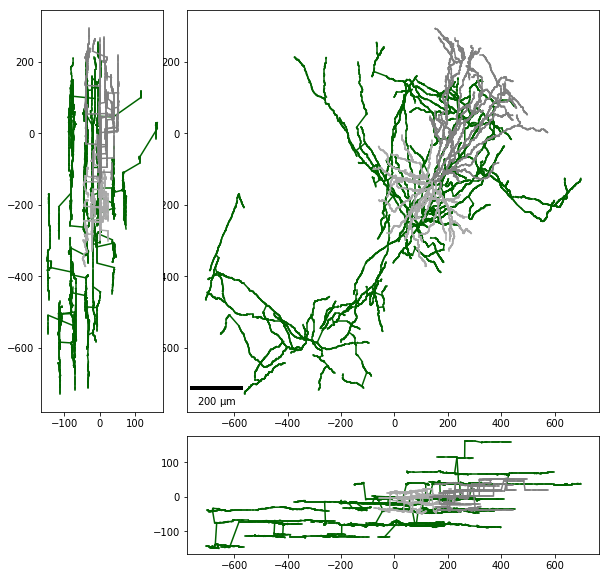

In [7]:
from neurontree.plotting import show_threeview

fig = plt.figure(figsize=(10,10))
show_threeview(N, fig)

### Plotting axon and dendrites indepedently

The above plot is a bit busy. The axon is large and entangled with the dendrites, so you might want to look at axons and dendrites independently.

In [8]:
Axon = N.get_axonal_tree()
Dendrites = N.get_dendritic_tree()

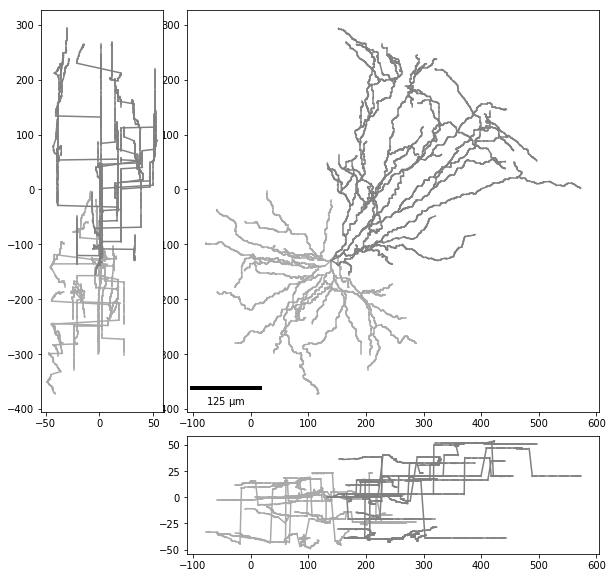

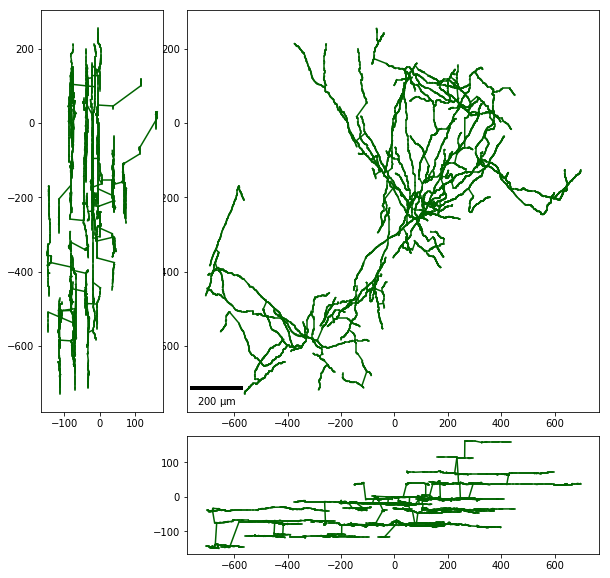

In [9]:
dendrite_fig = plt.figure(figsize=(10,10))
show_threeview(Dendrites, dendrite_fig)
plt.title('Dendrites')

axon_fig = plt.figure(figsize=(10,10))
show_threeview(Axon, axon_fig)
plt.title('Axon')

# Compute the Persistence Diagram

By default MorphoPy implements four different distance functions for persistence diagrams: radial distance to soma, path length to soma, height to soma, and branch order (to be found in computations.persistence_functions).


In [12]:
from computation.persistence_functions import path_length, radial_distance, height, branch_order
from computation.feature_presentation import get_persistence

In [16]:
filter_function = path_length

df = get_persistence(N.get_topological_minor(), f=filter_function) 
# we pass the topological minor here since persistence only operates on branch points anyways
df.head()

,birth,death,node_id,node_type
0,486.033861,470.121741,7911,4
1,522.786674,486.810094,3914,4
2,1994.380115,1908.622770,14377,2
3,850.798590,829.044053,19423,2
4,1056.353000,1049.563000,15814,2


However, one can also provide a custom distance function. It only needs to follow the form `function(networkx.DiGraph(), node_id_end, node_id_start)` and return the distance between start node and end node.

In [23]:
import numpy as np
def custom_distance(G, u, v):
    """
    Returns a distance between nodes u and v, which both are part of the graph given in G.
    """
    n = G.node[u]['pos']
    r = G.node[v]['pos']
    return np.dot(n, r)

In [22]:
df = get_persistence(N.get_topological_minor(), f=custom_distance) 
# we pass the topological minor here since persistence only operates on branch points anyways
df.head()

,birth,death,node_id,node_type
0,1733.0580,5611.0040,7890,4
1,13201.1053,18801.1695,3914,4
2,25189.1594,-27419.2678,14310,2
3,47205.7964,50601.7300,19423,2
4,37369.8922,38927.5021,15881,2


# Compute Morphometric Statistics

In [12]:
z = dict()

In [15]:
z['branch_points'] = N.get_branchpoints().size
extend = N.get_extend()

z['width'] = extend[0]
z['depth'] = extend[1]
z['height'] = extend[2]

tips = N.get_tips()

z['tips'] = tips.size

z['stems'] = len(N.edges(1))

z['total_length'] = np.sum(list(nx.get_edge_attributes(N.get_graph(), 'path_length').values()))
# get all radii
radii = nx.get_node_attributes(N.get_graph(), 'radius')
# delete the soma
radii.pop(N.get_root())
z['avg_thickness'] = np.mean(list(radii.values()))
z['max_thickness'] = np.max(list(radii.values()))

z['total_surface'] = np.sum(list(N.get_surface().values()))
z['total_volume'] = np.sum(list(N.get_volume().values()))

z['max_path_dist_to_soma'] = np.max(N.get_distance_dist()[1])
z['max_branch_order'] = np.max(list(N.get_branch_order().values()))

path_angles = []
for p1 in N.get_path_angles().items():
    if p1[1].values():
        path_angles += list(list(p1[1].values())[0].values())

z['max_path_angle'] = np.percentile(path_angles,99.5)
z['min_path_angle'] = np.min(path_angles)
z['median_path_angle'] = np.median(path_angles)

R = N.get_topological_minor()
segment_length = R.get_segment_length()
terminal_segment_pl = [item[1] for item in segment_length.items() if item[0][1] in tips]
intermediate_segment_pl = [item[1] for item in segment_length.items() if item[0][1] not in tips]

z['max_segment_path_length'] = np.max(list(segment_length.values()))
z['median_intermediate_segment_pl'] = np.median([0] + intermediate_segment_pl)
z['median_terminal_segment_pl'] = np.median(terminal_segment_pl)

tortuosity = [e[2]['path_length'] / e[2]['euclidean_dist'] for e in R.edges(data=True)]

z['max_tortuosity'] = np.log(np.percentile(tortuosity,99.5))
z['min_tortuosity'] = np.log(np.min(tortuosity))
z['median_tortuosity'] = np.log(np.median(tortuosity))

branch_angles = R.get_branch_angles()
z['max_branch_angle'] = np.max(branch_angles)
z['min_branch_angle'] = np.min(branch_angles)
z['mean_branch_angle'] = np.mean(branch_angles)

# get maximal degree within data
z['max_degree'] = np.max([item[1] for item in R.get_graph().out_degree().items() if item[0] != R.get_root()])

# get tree asymmetry
weights, psad = R.get_psad()
if np.sum(list(weights.values())) != 0:
    z['tree_asymmetry'] = np.sum([weights[k]*psad[k] for k in psad.keys()])/np.sum(list(weights.values()))
else:
    z['tree_asymmetry'] = 0

In [16]:
z

{'avg_thickness': 0.14393072521321548,
 'branch_points': 107,
 'depth': 86.65244811540327,
 'height': 128.29000000000002,
 'max_branch_angle': 178.18986330176983,
 'max_branch_order': 22,
 'max_degree': 3,
 'max_path_angle': 121.69340798976552,
 'max_path_dist_to_soma': 798.161003480817,
 'max_segment_path_length': 307.737173828897,
 'max_thickness': 7.47866586639495,
 'max_tortuosity': 1.8811878989560245,
 'mean_branch_angle': 74.57860493429285,
 'median_intermediate_segment_pl': 25.107882833940906,
 'median_path_angle': 10.151116766905487,
 'median_terminal_segment_pl': 64.9686058371587,
 'median_tortuosity': 0.2801999698731242,
 'min_branch_angle': 7.867697418883542,
 'min_path_angle': 0.0,
 'min_tortuosity': 0.00130087508079766,
 'stems': 5,
 'tips': 112,
 'total_length': 13251.659086698703,
 'total_surface': 12384.993191495898,
 'total_volume': 4515.048054157633,
 'tree_asymmetry': 0.7392180795087548,
 'width': 514.24}

# Compute Density Maps

In [18]:
# TODO

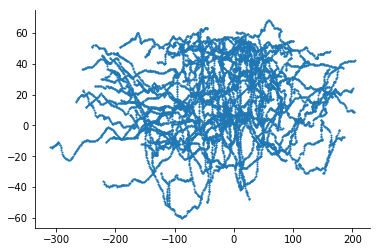